In [201]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)
import pandas as pd
import numpy as np

adult = pd.read_csv("adult_with_pii.csv")
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0


# Differentially Private Synthetic Data

In this section, we'll examine the problem of generating *synthetic data* using differentially private algorithms. Strictly speaking, the input of such an algorithm is an *original dataset*, and its output is a *synthetic dataset* with the same shape (i.e. same set of columns and same number of rows); in addition, we would like the *values* in the synthetic dataset to have the same properties as the corresponding values in the original dataset. For example, if we take our US Census dataset to be the original data, then we'd like our synthetic data to have a similar distribution of ages for the participants as the original data, and to preserve correlations between columns (e.g. a link between age and occupation).

Most algorithms for generating such synthetic data rely on a *synthetic representation* of the original dataset, which does *not* have the same shape as the original data, but which *does* allow answering queries about the original data. For example, if we *only* care about range queries over ages, then we could generate an age histogram - a count of how many participants in the original data had each possible age - and use the histogram to answer the queries. This histogram is a *synthetic representation* which is suitable for answering some queries, but it does not have the same shape as the original data, so it's not *synthetic data*.

Some algorithms simply use the synthetic representation to answer queries. Others use the synthetic representation to generate synthetic data. We'll look at one kind of synthetic representation - a histogram - and several methods of generating synthetic data from it.

## Synthetic Representation: a Histogram

We've already seen many histograms - they're a staple of differentially private analyses, since parallel composition can be immediately applied. We've also seen the concept of a *range query*, though we haven't used that name very much. As a first step towards synthetic data, we're going to design a synthetic representation for one column of the original dataset which is capable of answering range queries.

A *range query* counts the number of rows in the dataset which have a value lying in a given range. For example, "how many participants are between the ages of 21 and 33?" is a range query.

In [230]:
def range_query(df, col, a, b):
    return len(df[(df[col] >= a) & (adult[col] < b)])

range_query(adult, 'Age', 21, 33)

9878

We can define a histogram query which defines a histogram bin for each age between 0 and 100, and count the number of people in each bin using range queries. The result looks very much like the output of calling `plt.hist` on the data - because we've essentially computed the same result manually.

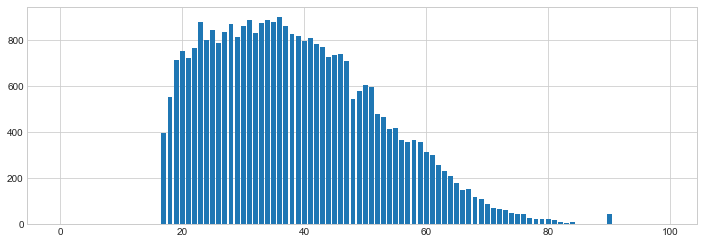

In [231]:
bins = list(range(0, 100))
counts = [range_query(adult, 'Age', b, b+1) for b in bins]
plt.bar(bins, counts);

We can use these histogram results as a synthetic representation for the original data! To answer a range query, we can add up all the counts of the bins which fall into the range.

In [232]:
def range_query_synth(syn_rep, a, b):
    total = 0
    for i in range(a, b):
        total += syn_rep[i]
    return total

In [233]:
range_query_synth(counts, 21, 33)

9878

Notice that we get *exactly* the same result, whether we issue the range query on the original data or our synthetic representation. We haven't lost any information from the original dataset (at least for the purposes of answering range queries over ages).

## Adding Differential Privacy

We can easily make our synthetic representation differentially private. We can add Laplace noise separately to each count in the histogram; by parallel composition, this satisfies $\epsilon$-differential privacy.

In [234]:
epsilon = 1
dp_syn_rep = [laplace_mech(c, 1, epsilon) for c in counts]

We can use the same function as before to answer range queries using our differentially private synthetic representation. By post-processing, these results also satisfy $\epsilon$-differential privacy; furthermore, since we're relying on post-processing, we can answer as many queries as we want without incurring additional privacy cost.

In [235]:
range_query_synth(dp_syn_data, 21, 33)

9881.369646763385

How accurate are the results? For small ranges, the results we get from our synthetic representation have very similar accuracy to the results we could get by applying the Laplace mechanism directly to the result of the range query we want to answer. For example:

In [236]:
true_answer = range_query(adult, 'Age', 30, 31)
print('Synthetic representation error: {}'.format(pct_error(true_answer, range_query_synth(dp_syn_rep, 30, 31))))
print('Laplace mechanism error: {}'.format(pct_error(true_answer, laplace_mech(true_answer, 1, epsilon))))

Synthetic representation error: 0.13107151800740763
Laplace mechanism error: 0.10894918573948237


As the range gets bigger, the count gets larger, so we would expect error to improve. We have seen this over and over again - larger groups means a stronger signal, which leads to lower relative error. With the Laplace mechanism, we see exactly this behavior. With our synthetic representation, however, we're adding together noisy results from many *smaller* groups - so as the signal grows, so does the noise! As a result, we see roughly the same magnitude of relative error when using the synthetic representation, *regardless of the size of the range* - precisely the opposite of the Laplace mechanism!

In [237]:
true_answer = range_query(adult, 'Age', 30, 71)
print('Synthetic representation error: {}'.format(pct_error(true_answer, range_query_synth(dp_syn_rep, 30, 71))))
print('Laplace mechanism error: {}'.format(pct_error(true_answer, laplace_mech(true_answer, 1, epsilon))))

Synthetic representation error: 0.024174057316677745
Laplace mechanism error: 0.003455813142360862


This difference demonstrates the drawback of our synthetic representation: it can answer any range query over the range it covers, but it might not offer the same accuracy as the Laplace mechanism. The major advantage of our synthetic representation is the ability to answer infinitely many queries without additional privacy budget; the major disadvantage is the loss in accuracy.

## Generating Tabular Data

The next step is to go from our synthetic representation to *synthetic data*. To do this, we want to treat our synthetic representation as a probability distribution that estimates the underlying distribution from which the original data was drawn, and sample from it. Because we're considering just a single column, and ignoring all the others, this is called a [*marginal distribution*](https://en.wikipedia.org/wiki/Marginal_distribution) (specifically, a *1-way marginal*).

Our strategy here will be simple: we have counts for each histogram bin; we'll normalize these counts so that they sum to 1, and then treat them as probabilities. Once we have these probabilities, we can sample from the distribution it represents by randomly selecting a bin of the histogram, weighted by the probabilities. Our first step is to prepare the counts, by ensuring that none is negative and by normalizing them to sum to 1:

In [238]:
dp_syn_rep_nn = np.clip(dp_syn_rep, 0, None)
syn_normalized = dp_syn_rep_nn / np.sum(dp_syn_rep_nn)
np.sum(syn_normalized)

1.0

Notice that if we plot the normalized counts - which we can now treat as probabilities for each corresponding histogram bin, since they sum to 1 - we see a shape that looks very much like the original histogram (which, in turn, looks a lot like the shape of the original data). This is all to be expected - except for their scale, these probabilities *are* simply the counts.

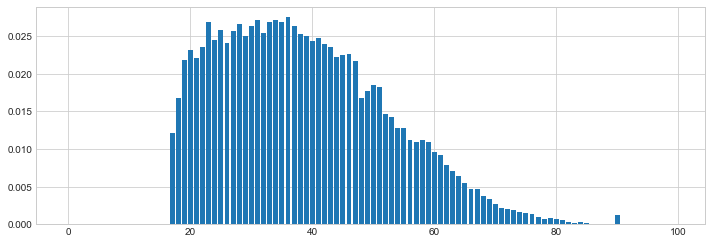

In [243]:
plt.bar(bins, syn_normalized);

The final step is to generate new samples based on these probabilities. We can use `np.random.choice`, which allows passing in a list of probabilities (in the `p` parameter) associated with the choices given in the first parameter. It implements exactly the weighted random selection that we need for our sampling task. We can generate as many samples as we want without additional privacy cost, since we've already made our counts differentially private.

In [262]:
def gen_samples(n):
    return np.random.choice(bins, n, p=syn_normalized)

syn_data = pd.DataFrame(gen_samples(5), columns=['Age'])
syn_data

,Age
0,58
1,57
2,45
3,33
4,54


The samples we generate this way will be roughly distributed - we hope - according to the same underlying distribution as the original data. That means we can use the generated synthetic data to answer the same queries we could answer using the original data. In particular, if we plot the histogram of ages in a large synthetic data set, we'll see the same shape as we did in the original data.

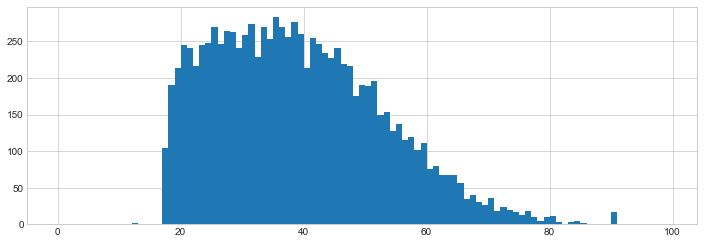

In [275]:
syn_data = pd.DataFrame(gen_samples(10000), columns=['Age'])
plt.hist(syn_data['Age'], bins=bins);

We can also answer other queries we've seen in the past, like averages and range queries:

In [276]:
print('Mean age, synthetic: {}'.format(np.mean(syn_data['Age'])))
print('Mean age, true answer: {}'.format(np.mean(adult['Age'])))
print('Percent error: {}'.format(pct_error(np.mean(syn_data['Age']), np.mean(adult['Age']))))

Mean age, synthetic: 38.5542
Mean age, true answer: 38.58164675532078
Percent error: 0.07119005275892468


In [277]:
print('Mean age, synthetic: {}'.format(range_query(syn_data, 'Age', 20, 65)))
print('Mean age, true answer: {}'.format(range_query(adult, 'Age', 20, 65)))
print('Percent error: {}'.format(pct_error(range_query(adult, 'Age', 20, 65), 
                                           range_query(syn_data, 'Age', 20, 65))))

Mean age, synthetic: 9118
Mean age, true answer: 29568
Percent error: 69.16260822510823


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Our mean query has fairly low error (though still much larger than we would achieve by applying the Laplace mechanism directly). Our range query, however, has very large error! This is simply because we haven't quite matched the shape of the original data - we only generated 10,000 samples, and the original data set has more than 30,000 rows. We can perform an additional differentially private query to determine the number of rows in the original data, and then generate a new synthetic data set with the same number of rows, and this will improve our range query results.

In [295]:
n = laplace_mech(len(adult), 1, 1.0)
syn_data = pd.DataFrame(gen_samples(int(n)), columns=['Age'])

print('Mean age, synthetic: {}'.format(range_query(syn_data, 'Age', 20, 65)))
print('Mean age, true answer: {}'.format(range_query(adult, 'Age', 20, 65)))
print('Percent error: {}'.format(pct_error(range_query(adult, 'Age', 20, 65), 
                                           range_query(syn_data, 'Age', 20, 65))))

Mean age, synthetic: 29565
Mean age, true answer: 29568
Percent error: 0.010146103896103896


Now we see the lower error we expect.

## Generating More Columns

So far we've generated synthetic data that matches the number of rows of the original data set, and is useful for answering queries about the original data, but it has only a single column! How do we generate more columns?

There are two basic approaches. We could repeat the process we followed above for each of $k$ columns (generating $k$ 1-way marginals), and arrive at $k$ separate synthetic data sets, each with a single column. Then, we could smash these data sets together to construct a single data set with $k$ columns. This approach is straightforward, but since we consider each column in isolation, we'll lose correlations *between* columns that existed in the original data. For example, it might be the case that age and occupation are correlated in the data (e.g. managers are more likely to be old than they are to be young); if we consider each column in isolation, we'll get the *number* of 18-year-olds and the *number* of managers correct, but we may be very wrong about the number of 18-year-old managers.

The other approach is to consider multiple columns together. For example, we can consider both age and occupation at the same time, and count how many 18-year-old managers there are, how many 19-year-old managers there are, and so on. The result of this modified process is a 2-way marginal distribution. We'll end up considering all possible combinations of age and occupation - which is exactly what we did when we built contingency tables earlier! For example:

In [192]:
ct = pd.crosstab(adult['Age'], adult['Occupation'])
ct.head()

Occupation,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
Age,,,,,,,,,,,,,,
17,23,0,14,1,9,40,2,129,8,10,3,87,1,3
18,55,0,17,6,14,50,17,152,4,10,5,115,2,8
19,102,0,40,12,24,65,30,166,3,18,3,112,8,16
20,117,0,35,15,23,81,41,139,3,28,9,108,14,24
21,121,0,59,18,25,51,51,142,4,30,7,93,16,14


Now we can do exactly what we did before - add noise to these counts, then normalize them and treat them as probabilities! Each count now corresponds to a *pair* of values - both an age and an occupation - so when we sample from the distribution we have constructed, we'll get both values at once.

In [211]:
dp_ct = ct.applymap(lambda x: max(laplace_mech(x, 1, 1), 0))
dp_vals = dp_ct.stack().reset_index().values.tolist()
probs = [p for _,_,p in dp_vals]
vals = [(a,b) for a,b,_ in dp_vals]
probs_norm = probs / np.sum(probs)
list(zip(vals, probs_norm))[0]

((17, 'Adm-clerical'), 0.0007301377628952574)

Examining the first element of the probabilities, we find that we'll have a 0.07% chance of generating a row representing a 17-year-old clerical worker. Now we're ready to generate some rows! We'll first generate a list of indices into the `vals` list, then generate rows by indexing into `vals`; we have to do this because `np.random.choice` won't accept a list of tuples in the first argument.

In [212]:
indices = range(0, len(vals))
n = laplace_mech(len(adult), 1, 1.0)
gen_indices = np.random.choice(indices, int(n), p=probs_norm)
syn_data = [vals[i] for i in gen_indices]

syn_df = pd.DataFrame(syn_data, columns=['Age', 'Occupation'])
syn_df.head()

,Age,Occupation
0,22,Prof-specialty
1,31,Craft-repair
2,26,Craft-repair
3,60,Other-service
4,33,Exec-managerial


The downside of considering two columns at once is that our accuracy will be lower. As we add more columns to the set we're considering (i.e., build an $n$-way marginal, with increasing values of $n$), we see the same effect we did with contingency tables - each count gets smaller, so the signal gets smaller relative to the noise, and our results are not as accurate. We can see this effect by plotting the histogram of ages in our new synthetic data set; notice that it has approximately the right shape, but it's less smooth than either the original data or the differentially private counts we used for the age column by itself.

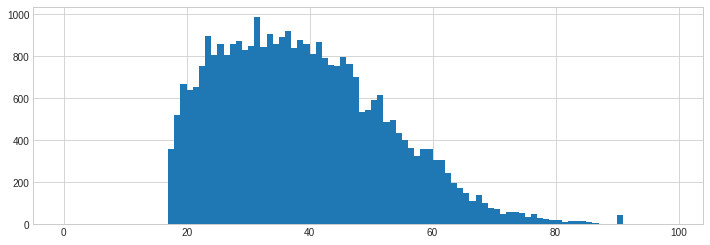

In [213]:
plt.hist(syn_df['Age'], bins=bins);

We see the same loss in accuracy when we try specific queries on just the age column:

In [214]:
real_answer = range_query(adult, 'Age', 20, 30)
syn_answer = range_query(syn_df, 'Age', 20, 30)
pct_error(real_answer, syn_answer)

14.812515520238389

## Summary

- A *synthetic representation* of a data set allows answering queries about the original data
- One common example of a synthetic representation is a histogram, which can be made differentially private by adding noise to its counts
- A histogram representation can be used to generate *synthetic data* with the same shape as the original data by treating its counts as probabilities: normalize the counts to sum to 1, then sample from the histogram bins using the corresponding normalized counts as probabilities
- The normalized histogram is a representation of a *1-way marginal distribution*, which captures the information in a single column in isolation
- A 1-way marginal does *not* capture correlations between columns
- To generate multiple columns, we can use multiple 1-way marginals, or we can construct a representation of a $n$-way marginal where $n>1$
- Differentially private $n$-way marginals become increasingly noisy as $n$ grows, since a larger $n$ implies a smaller count for each bin of the resulting histogram
- The challenging tradeoff in generating synthetic data is thus:
  - Using multiple 1-way marginals loses correlation between columns
  - Using a single $n$-way marginal tends to be very inaccurate
- In many cases, generating synthetic data which is both accurate and captures the important correlations between columns is likely to be impossible